In [415]:
## Manipulación de datos
import pandas as pd
import numpy as np
import polars as pl
## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Modelos
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [416]:
df = pd.read_parquet(r'..\data\processed\realtor-ml.parquet')

In [417]:
df.head()

,price,zip_code,house_size,size_bin,property_type,bed_group,bath_group,price_category,is_luxury_home,bed_bath_ratio,...,state_Utah,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,status_ready_to_build,status_sold
0,105000.0,601.0,920.0,2,0,3,2,0,0,1.499999,...,0,0,0,0,0,0,0,0,0,0
1,80000.0,601.0,1527.0,4,0,4,2,0,0,1.999999,...,0,0,0,0,0,0,0,0,0,0
2,67000.0,795.0,748.0,2,0,2,1,0,0,1.999998,...,0,0,0,0,0,0,0,0,0,0
3,145000.0,731.0,1800.0,4,0,4,2,0,0,1.999999,...,0,0,0,0,0,0,0,0,0,0
4,179000.0,612.0,2520.0,5,0,4,3,0,0,1.333333,...,0,0,0,0,0,0,0,0,0,0


In [418]:
df.shape

(1649585, 69)

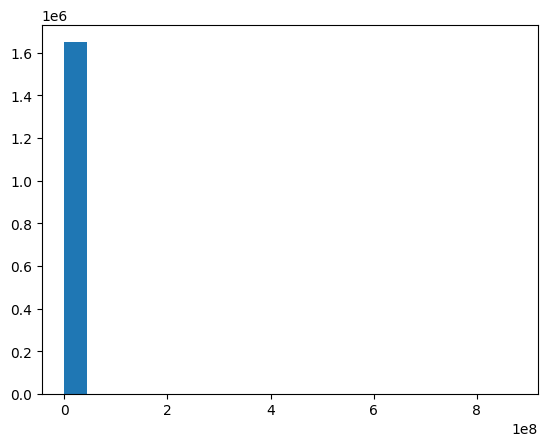

In [419]:
plt.hist(df['price'],bins=20);

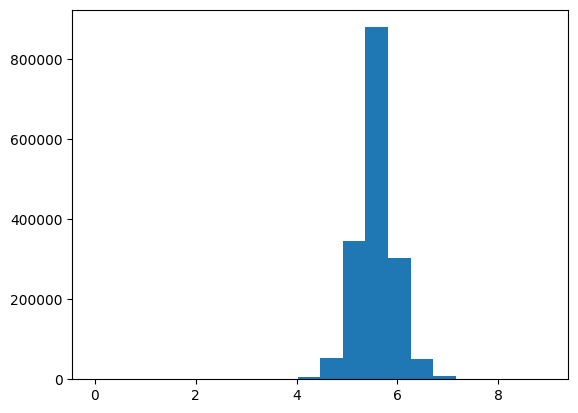

In [420]:
plt.hist(np.log10(df['price']),bins=20);

In [421]:
df = df[(df['price'] >= 10000) & (df['price'] <= 10_000_000)]

In [422]:
correlations = df.corr()['price']
correlations

price                    1.000000
zip_code                 0.102631
house_size               0.150517
size_bin                 0.401581
property_type            0.183618
                           ...   
state_West Virginia     -0.030049
state_Wisconsin         -0.034524
state_Wyoming            0.006089
status_ready_to_build   -0.004680
status_sold             -0.054594
Name: price, Length: 69, dtype: float64

In [423]:
df['price_range'] = pd.cut(df['price'], bins=[0, 500_000, 1_000_000, np.inf], labels=[0,1,2])

In [424]:
X = df.drop(columns=['price', 'price_category', 'is_luxury_home', 'price_per_sqft','property_type','bath_group','bed_group','price_range'])
y = np.log1p(df['price'])

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [426]:
from sklearn.preprocessing import StandardScaler

num_cols = ['house_size', 'bed_bath_ratio', 'total_rooms']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,     
    n_jobs=-1,
)

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

In [428]:
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [429]:
print('RMSE RandomForest data set General', round(root_mean_squared_error(y_test,rf_pred),2)*100)
print('MAPE RandomForest data set General', round(mean_absolute_percentage_error(y_test,rf_pred),2)*100)

RMSE RandomForest data set General 77.0
MAPE RandomForest data set General 5.0


In [431]:
price_range_test = df.loc[X_test.index, 'price_range']
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

for segment in [0, 1, 2]:
    mask = price_range_test == segment
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100
    print(f"Segmento {segment} → MAPE randonforest: {mape:.2f}")

Segmento 0 → MAPE randonforest: 140.37
Segmento 1 → MAPE randonforest: 34.87
Segmento 2 → MAPE randonforest: 40.16


In [311]:
import pandas as pd
import numpy as np

# Convertimos las predicciones log a precio real
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(rf_pred)

# Crear rango de precios
price_range = pd.cut(y_test_real, bins=[0, 500_000, 1_000_000, np.inf], labels=['bajo', 'medio', 'alto'])

# Crear DataFrame para análisis
df_eval = pd.DataFrame({
    'real': y_test_real,
    'pred': y_pred_real,
    'rango': price_range
})

# Calcular MAPE por rango
print(df_eval.groupby('rango').apply(lambda g: np.mean(np.abs((g['real'] - g['pred']) / g['real'])) * 100))


rango
bajo     4291.046863
medio      14.814007
alto       28.520892
dtype: float64


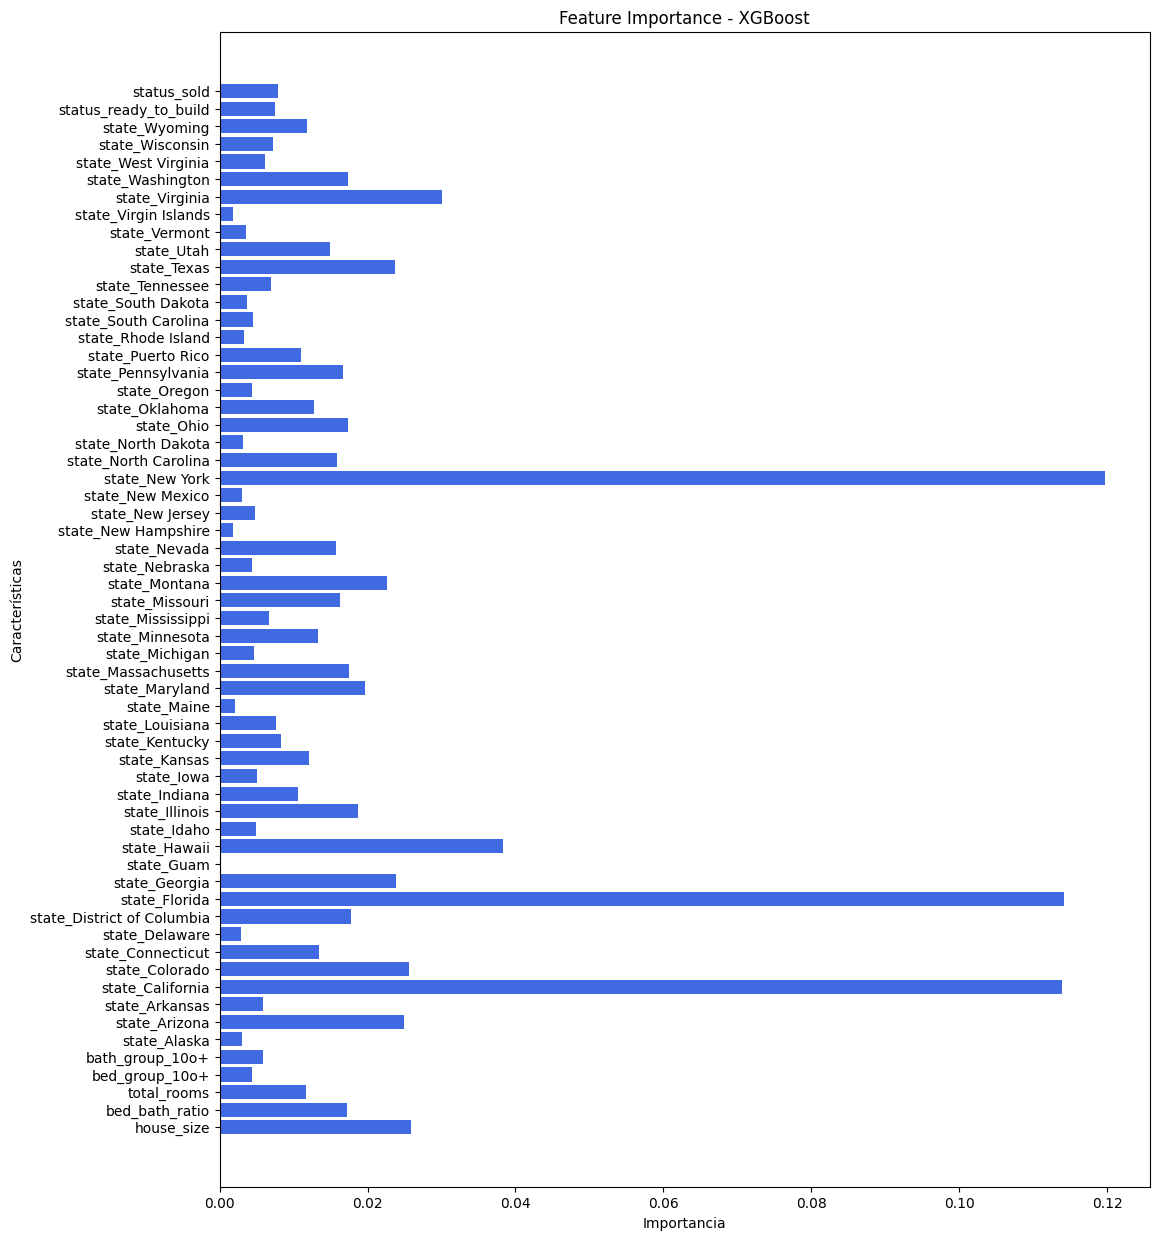

In [281]:
feature_importances = xgb.feature_importances_

# Obtener los nombres de las características seleccionadas
selected_feature_names = X_train.columns # Obtener solo las columnas seleccionadas

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    "Feature": selected_feature_names,  # Usar los nombres reales de las columnas seleccionadas
    "Importance": feature_importances
})

# Graficar la importancia de las características
plt.figure(figsize=(12, 15))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Feature Importance - XGBoost")
plt.show()

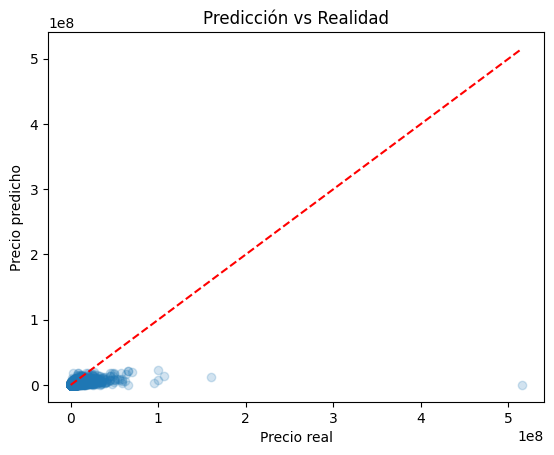

In [ ]:
plt.scatter(np.expm1(y_test), np.expm1(rf_pred), alpha=0.2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Predicción vs Realidad")
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.show()
